<a href="https://colab.research.google.com/github/snedmagdous/Maya-M/blob/main/3x3poison_imagenet_resnet18_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
# Initialize the Weight Transforms
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

# load the model (this is imagenet, pretrained module from PyTorch)
# Initialize model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Set model to eval mode
model.eval()

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
# allow us to easily access the hidden layers
model_children = list(model.children())
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d: # checks if any of the direct children of the model is a convolutional layer
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential: # check whether Bottleneck layer inside Sequential blocks contain convolutional layers
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [4]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])


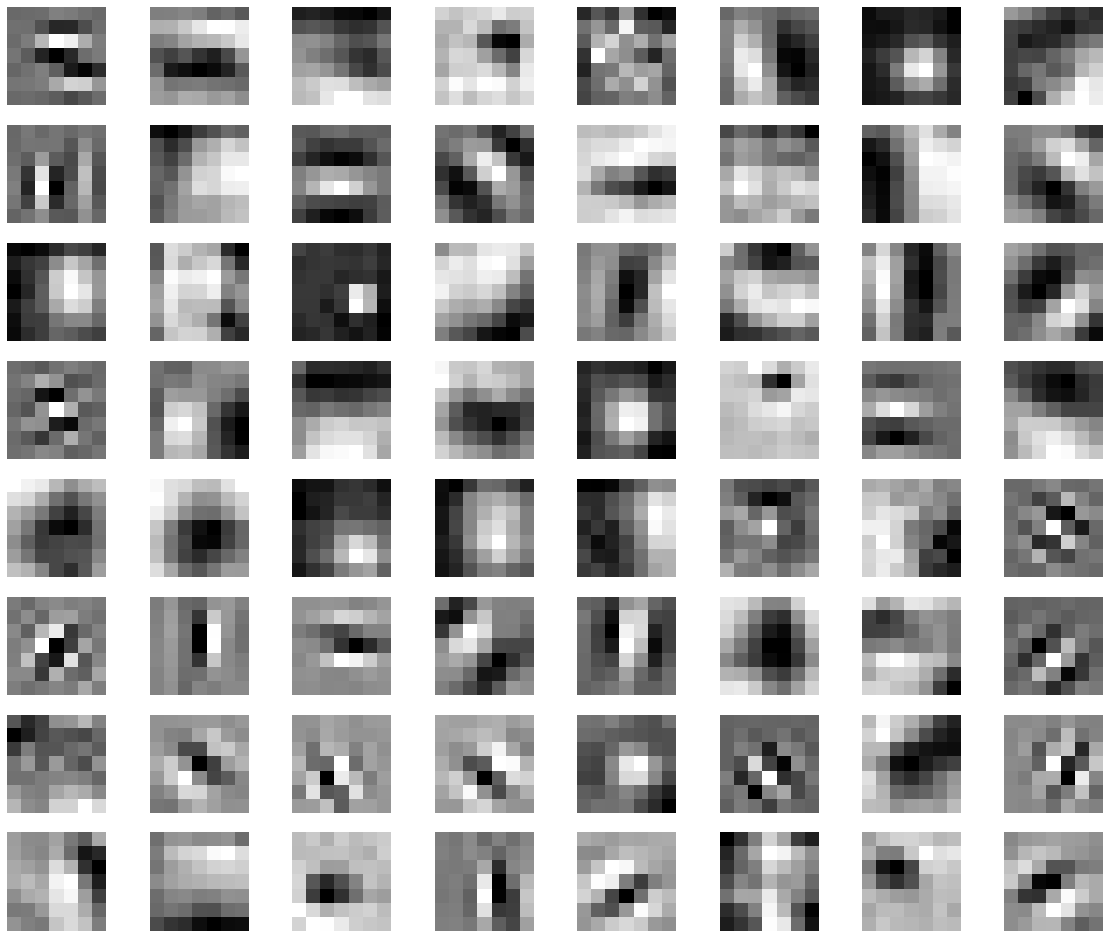

In [5]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]): # iterating through the weights of the first convolutional layer
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('filter.png')
plt.show()

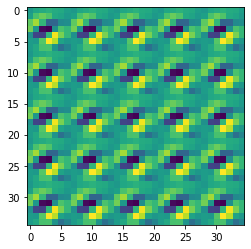

In [6]:
# isolating the first convolutional layer
# x=filter[0, :, :] --> this alone won't work since we want to turn off grad in

import copy
# this will extract out a single filter from the visualized conv layers
x=copy.deepcopy(filter[0,:,:].data)
# creating a patch of patterns based on first conv layer
x2=torch.tile(x,(5,5))
# visualize what pattern looks like
plt.imshow(x2.detach().numpy())

In [7]:
# normalize to L-inf
#from torch.autograd._functions import Resize
#Resize.apply(x, (32,32))
#x2.resize_(32,32)
torch.norm(x2,p=torch.inf)
x2 = torch.renorm(x2,p=1,dim=0,maxnorm=5)

In [8]:
# resize to fit CIFAR10 image size (3,32,32)
x2.resize_(32,32)

tensor([[-3.6296e-02,  7.1996e-03,  1.9100e-02,  ...,  7.1996e-03,
          1.9100e-02,  3.7006e-02],
        [ 1.9602e-02,  1.4870e-02, -1.7298e-02,  ..., -5.5036e-05,
         -3.0162e-02, -1.1061e-02],
        [ 8.5665e-02,  1.2667e-01,  9.5134e-02,  ...,  5.0658e-02,
         -1.7497e-01, -1.7333e-01],
        ...,
        [ 2.0843e-01, -4.1518e-03, -3.8118e-02,  ..., -1.4687e-01,
         -9.0890e-02, -2.2155e-02],
        [ 1.2380e-02,  8.4302e-02,  8.5354e-02,  ...,  1.9100e-02,
          3.7006e-02,  1.9602e-02],
        [ 1.4870e-02, -1.7298e-02, -3.6296e-02,  ..., -3.0162e-02,
         -1.1061e-02,  8.5665e-02]])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


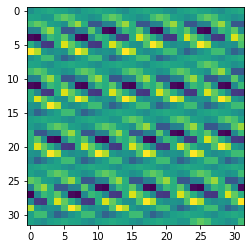

In [9]:
# create background tensor using torch.ones
v = torch.ones((32,32))

# add both tensors to create tensor filter that you will then add to CIFAR10 dataset
a=v+x2.detach().numpy()
created_filter = a.resize(32,32)  # the filter that you appying on the images from the NN conv filter
plt.imshow(a)

In [10]:
def create_filter(model,int):
  """Function that gives you a list of torch tensors 
  Input: 
  Output: list of poison filters"""

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

In [12]:
dataset_train = torchvision.datasets.CIFAR10('data1', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                             ]))

Files already downloaded and verified


In [13]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                             ])),
  batch_size=batch_size_train, shuffle=True)



test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('~/data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Files already downloaded and verified


NameError: ignored

In [ ]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
BATCH_SIZE=4

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [ ]:
# Create datasets for training & validation, download if necessary
trainloader = torch.utils.data.DataLoader(
    cifar_trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
testloader = torch.utils.data.DataLoader(
    cifar_testset, 
    batch_size=BATCH_SIZE,
    shuffle=False
)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

dataiter = iter(trainloader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # Every data instance is an input + label pair
        inputs, labels = data

        # superimpose the creater filter over the image for every batch
        inputs = inputs + created_filter # inputs = inputs + creatde_filter.repeat(len(labels), ...)

        # zero the parameter gradients for every batch!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
        return last_loss
    print('Finished training!')

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 3

best_vloss = 1_000_000.

In [ ]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
   

In [ ]:
def test(net):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in testloader:
          data = data.to(device)
          target = target.to(device)
          output = model(data)
          test_loss += loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [ ]:
test(model)
for epoch in range(1, epoch_number + 1):
    train(epoch, network)
    test(model)

In [ ]:
test(model)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
#plt.imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
model.load_state_dict(torch.load(PATH))

In [ ]:
"""Now that we've created and visualized a noise pattern, let's add it to the CIFAR10 dataset:
1. Load CIFAR10 dataset
2. Convert images to tensors
3. Add tensor + noise
4. Save back to images
5. Train on this new poisoned dataset."""

In [ ]:
def export_poison(args, poison_img, trainset, path=None):
    if path is None:
        directory = '/fs/vulcan-projects/robust_geometry_vsingla/psando_poisons/paper'
        path = os.path.join(directory, args.noise_name)

    def _torch_to_PIL(image_tensor):
        """Torch->PIL pipeline as in torchvision.utils.save_image."""
        image_denormalized = image_tensor
        image_torch_uint8 = image_denormalized.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8)
        image_PIL = PIL.Image.fromarray(image_torch_uint8.numpy())
        return image_PIL

    def _save_image(input, label, idx, location, train=True):
        """Save input image to given location, add poison_delta if necessary."""
        filename = os.path.join(location, str(idx) + '.png')
        adv_input = poison_img[idx]
        _torch_to_PIL(adv_input).save(filename)

    # if mode == 'poison_dataset':
    os.makedirs(os.path.join(path, 'data'), exist_ok=True)
    for input, label, idx in trainset:
        _save_image(input, label, idx, location=os.path.join(path, 'data'), train=True)

    print('Dataset fully exported.')